# Imports, load features and target

In [ ]:
import importlib
import utils.utility_functions as utilityFunctions
importlib.reload(utilityFunctions)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'utilityFunctions' from '/workspaces/mlops-fake-news-prediction/utilityFunctions.py'>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from utils.utility_functions import get_sentiment, test_feature_sets, remove_outliers, evaluate, load_file_s3, upload_to_s3, log_model

import pandas as pd
import mlflow
import numpy as np
import itertools
import time
import joblib
import matplotlib.pyplot as plt

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
X_train = load_file_s3('fake-news-prediction', 'datasets/X_train.parquet', 'parquet')
X_val = load_file_s3('fake-news-prediction', 'datasets/X_val.parquet', 'parquet')
X_test = load_file_s3('fake-news-prediction', 'datasets/X_test.parquet', 'parquet')

y_train = load_file_s3('fake-news-prediction', 'datasets/y_train.csv', 'csv')
y_val = load_file_s3('fake-news-prediction', 'datasets/y_val.csv', 'csv')
y_test = load_file_s3('fake-news-prediction', 'datasets/y_val.csv', 'csv')

y_train = y_train.loc[:, 'label']
y_val = y_val.loc[:, 'label']
#y_test = y_test.loc[:, 'label']

In [3]:
# Add new feature sentiment scores
X_train['sentiment'] = X_train['text'].apply(get_sentiment)
X_val['sentiment'] = X_val['text'].apply(get_sentiment)
X_test['sentiment'] = X_test['text'].apply(get_sentiment)

# Feature Transformation

**Description of the Feature Transformation Code**

When training a model, the choice of features plays a crucial role. In this code, different feature sets are created and tested to find out which combination yields the best results.

The features consist of:
- **Bag-of-Words (BoW)**: A classic method of converting text into a numerical form. It counts how often a word appears in a document.
- **TF-IDF (Term Frequency - Inverse Document Frequency)**: An alternative method that not only considers the frequency of a word but also its relevance across the entire corpus.
- **Numerical Features**: In addition to the text data, the dataset contains numerical columns that describe various properties of the text, such as word count or average word length.

**Four Different Feature Sets**

The code tests four different combinations of features:

BoW Only (bow_only):
- The text column (title_text_clean) is converted into a numerical representation using CountVectorizer().
- All other columns are ignored.

TF-IDF Only (tfidf_only):
- Similar to bow_only, but uses TfidfVectorizer() to weight the importance of words.

BoW + Numerical Features (bow_num):
- The text column is vectorized using CountVectorizer().
- The numerical columns are left unchanged.

TF-IDF + Numerical Features (tfidf_num):
- The text column is vectorized using TfidfVectorizer().
- The numerical columns are also included.

In [4]:
# BoW only
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train['title_text_clean'])
X_val_bow = count_vectorizer.transform(X_val['title_text_clean'])

In [5]:
# TF-IDF only
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['title_text_clean'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['title_text_clean'])

In [ ]:
# BoW + Numerical Features
# Drop unused columns
X_train_pre = X_train.drop(columns=['text', 'title', 'title_text', 'language'], errors='ignore')
X_val_pre = X_val.drop(columns=['text', 'title', 'title_text', 'language'], errors='ignore')

# define columns to preprocess
num_cols = X_train_pre.select_dtypes(include=['number']).columns.tolist()
text_col = 'title_text_clean'

# Define preprocessor for Bag of words vectorization (Numerical columns remain unchanged)
preprocessor_bow = ColumnTransformer([
    ('text', CountVectorizer(), text_col)
], remainder='passthrough')

# Perform transformation
X_train_bow_num = preprocessor_bow.fit_transform(X_train_pre)
X_val_bow_num = preprocessor_bow.transform(X_val_pre)

In [7]:
# TF-IDF + Numerical Features
# Define preprocessor for tfidf vectorization (Numerical columns remain unchanged)
preprocessor_tfidf = ColumnTransformer([
    ('text', TfidfVectorizer(), text_col)
], remainder='passthrough')

# Perform transformation
X_train_tfidf_num = preprocessor_tfidf.fit_transform(X_train_pre)
X_val_tfidf_num = preprocessor_tfidf.transform(X_val_pre)

In [10]:
feature_sets = {
    "bow_only": X_train_bow,
    "tfidf_only": X_train_tfidf,
    "bow_num": X_train_bow_num,
    "tfidf_num": X_train_tfidf_num
}

validation_sets = {
    "bow_only": X_val_bow,
    "tfidf_only": X_val_tfidf,
    "bow_num": X_val_bow_num,
    "tfidf_num": X_val_tfidf_num
}

# Test different feature sets

## Train  Random Forest

In [87]:
test_feature_sets(RandomForestClassifier(random_state=0, n_jobs=-1), feature_sets, y_train, validation_sets, y_val)

classification report for feature set: bow_only
              precision    recall  f1-score   support

        Real      0.936     0.880     0.907      5414
        Fake      0.910     0.953     0.931      6866

    accuracy                          0.921     12280
   macro avg      0.923     0.916     0.919     12280
weighted avg      0.921     0.921     0.920     12280

classification report for feature set: tfidf_only
              precision    recall  f1-score   support

        Real      0.925     0.890     0.907      5414
        Fake      0.916     0.943     0.929      6866

    accuracy                          0.920     12280
   macro avg      0.920     0.917     0.918     12280
weighted avg      0.920     0.920     0.919     12280

classification report for feature set: bow_num
              precision    recall  f1-score   support

        Real      0.934     0.892     0.913      5414
        Fake      0.918     0.951     0.934      6866

    accuracy                         

## Train XGBoost

              precision    recall  f1-score   support

        Real      0.959     0.972     0.965      5414
        Fake      0.978     0.967     0.972      6866

    accuracy                          0.969     12280
   macro avg      0.968     0.970     0.969     12280
weighted avg      0.969     0.969     0.969     12280



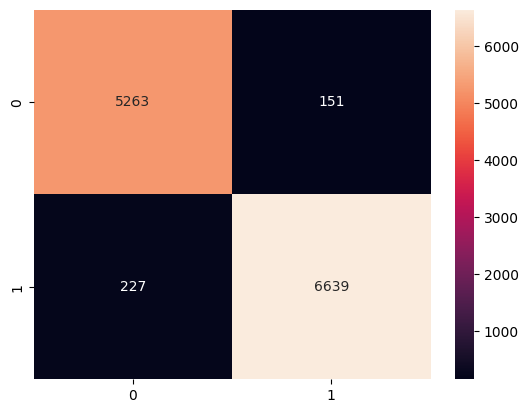

In [10]:
xgb_bow = XGBClassifier(random_state=0, n_jobs=-1)
xgb_bow.fit(X_train_bow, y_train)
y_pred_bow_xgb = xgb_bow.predict(X_val_bow)
evaluate(y_val, y_pred_bow_xgb)

              precision    recall  f1-score   support

        Real      0.964     0.975     0.970      5414
        Fake      0.980     0.971     0.976      6866

    accuracy                          0.973     12280
   macro avg      0.972     0.973     0.973     12280
weighted avg      0.973     0.973     0.973     12280



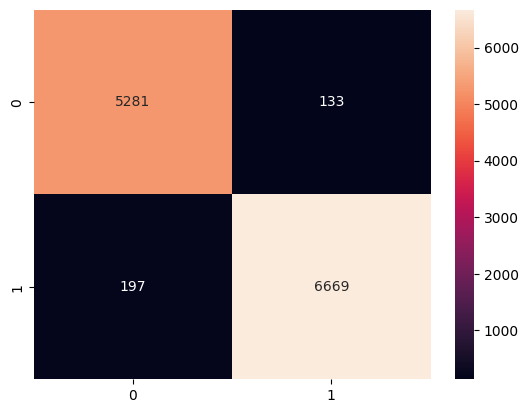

In [11]:
xgb_bow_num = XGBClassifier(random_state=0, n_jobs=-1)
xgb_bow_num.fit(X_train_bow_num, y_train)
y_pred_bow_xgb = xgb_bow_num.predict(X_val_bow_num)
evaluate(y_val, y_pred_bow_xgb)

              precision    recall  f1-score   support

        Real      0.954     0.970     0.962      5414
        Fake      0.976     0.963     0.970      6866

    accuracy                          0.966     12280
   macro avg      0.965     0.967     0.966     12280
weighted avg      0.966     0.966     0.966     12280



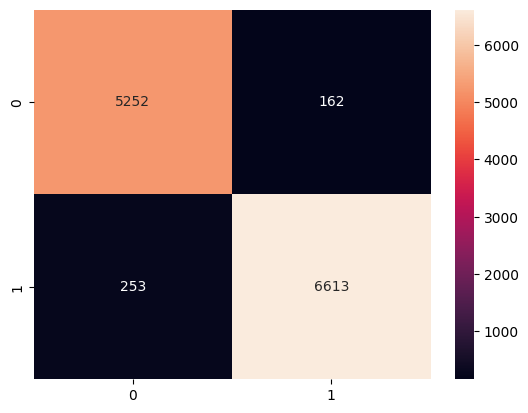

In [9]:
xgb_tfidf = XGBClassifier(random_state=0, n_jobs=-1)
xgb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_xgb = xgb_tfidf.predict(X_val_tfidf)
evaluate(y_val, y_pred_tfidf_xgb)

In [ ]:
xgb_tfidf_num = XGBClassifier(random_state=0, n_jobs=-1)
xgb_tfidf_num.fit(X_train_tfidf_num, y_train)
y_pred_tfidf_xgb = xgb_tfidf_num.predict(X_val_tfidf_num)
evaluate(y_val, y_pred_tfidf_xgb)

## Train LightGBM

In [11]:
feature_sets_lgbm = {
    "bow_only": X_train_bow.astype(np.float32),
    "tfidf_only": X_train_tfidf.astype(np.float32),
    "bow_num": X_train_bow_num.astype(np.float32),
    "tfidf_num": X_train_tfidf_num.astype(np.float32)
}

validation_sets_lgbm = {
    "bow_only": X_val_bow.astype(np.float32),
    "tfidf_only": X_val_tfidf.astype(np.float32),
    "bow_num": X_val_bow_num.astype(np.float32),
    "tfidf_num": X_val_tfidf_num.astype(np.float32)
}

In [12]:
test_feature_sets(lgb.LGBMClassifier(random_state=0, n_jobs=-1), feature_sets_lgbm, y_train, validation_sets_lgbm, y_val)

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.912607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100778
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18452
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


classification report for feature set: bow_only
              precision    recall  f1-score   support

        Real      0.956     0.972     0.964      5414
        Fake      0.978     0.965     0.971      6866

    accuracy                          0.968     12280
   macro avg      0.967     0.969     0.968     12280
weighted avg      0.968     0.968     0.968     12280

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.734035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1171654
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18452
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


classification report for feature set: tfidf_only
              precision    recall  f1-score   support

        Real      0.954     0.968     0.961      5414
        Fake      0.975     0.964     0.969      6866

    accuracy                          0.966     12280
   macro avg      0.964     0.966     0.965     12280
weighted avg      0.966     0.966     0.966     12280

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.646987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


classification report for feature set: bow_num
              precision    recall  f1-score   support

        Real      0.964     0.976     0.970      5414
        Fake      0.981     0.971     0.976      6866

    accuracy                          0.973     12280
   macro avg      0.972     0.973     0.973     12280
weighted avg      0.973     0.973     0.973     12280

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.085007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1173654
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


classification report for feature set: tfidf_num
              precision    recall  f1-score   support

        Real      0.963     0.975     0.969      5414
        Fake      0.980     0.970     0.975      6866

    accuracy                          0.972     12280
   macro avg      0.972     0.973     0.972     12280
weighted avg      0.973     0.972     0.972     12280



## Train LinearSVC

In [14]:
test_feature_sets(LinearSVC(random_state=0, max_iter=8000), feature_sets, y_train, validation_sets, y_val)

classification report for feature set: bow_only
              precision    recall  f1-score   support

        Real      0.936     0.930     0.933      5414
        Fake      0.945     0.950     0.947      6866

    accuracy                          0.941     12280
   macro avg      0.941     0.940     0.940     12280
weighted avg      0.941     0.941     0.941     12280

classification report for feature set: tfidf_only
              precision    recall  f1-score   support

        Real      0.952     0.950     0.951      5414
        Fake      0.960     0.962     0.961      6866

    accuracy                          0.957     12280
   macro avg      0.956     0.956     0.956     12280
weighted avg      0.957     0.957     0.957     12280



/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


classification report for feature set: bow_num
              precision    recall  f1-score   support

        Real      0.932     0.930     0.931      5414
        Fake      0.945     0.947     0.946      6866

    accuracy                          0.939     12280
   macro avg      0.938     0.938     0.938     12280
weighted avg      0.939     0.939     0.939     12280

classification report for feature set: tfidf_num
              precision    recall  f1-score   support

        Real      0.938     0.407     0.567      5414
        Fake      0.677     0.979     0.800      6866

    accuracy                          0.727     12280
   macro avg      0.807     0.693     0.684     12280
weighted avg      0.792     0.727     0.697     12280



/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Check with and without Outliers

In [14]:
print(len(X_train))
X_train_no, y_train_no = remove_outliers(X_train, y_train, num_cols, threshold=3, iterations=1)
print(len(X_train_no))

36840
0
24701


In [15]:
tfidf_vectorizer = TfidfVectorizer()
X_train_no = tfidf_vectorizer.fit_transform(X_train_no['title_text_clean'])
X_val_no = tfidf_vectorizer.transform(X_val['title_text_clean'])

## RandomForest

              precision    recall  f1-score   support

        Real      0.894     0.878     0.886      5414
        Fake      0.905     0.918     0.911      6866

    accuracy                          0.900     12280
   macro avg      0.900     0.898     0.899     12280
weighted avg      0.900     0.900     0.900     12280



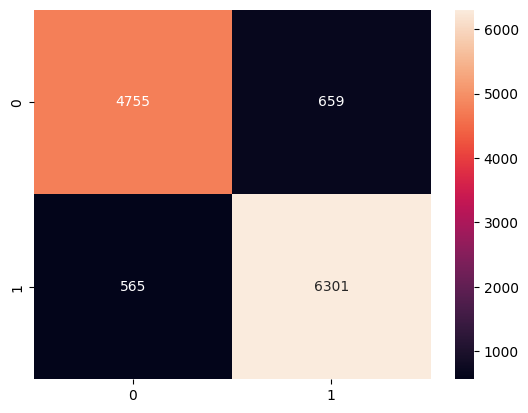

In [17]:
rf_tfidf_no = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_tfidf_no.fit(X_train_no, y_train_no)
y_pred_no = rf_tfidf_no.predict(X_val_no)
evaluate(y_val, y_pred_no)

## XGBoost

              precision    recall  f1-score   support

        Real      0.954     0.960     0.957      5414
        Fake      0.968     0.963     0.966      6866

    accuracy                          0.962     12280
   macro avg      0.961     0.961     0.961     12280
weighted avg      0.962     0.962     0.962     12280



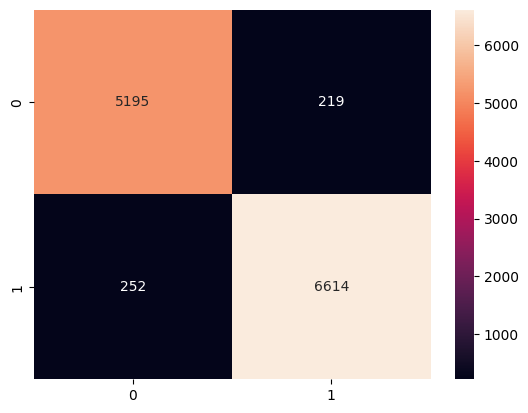

In [19]:
xgb_tfidf_no = XGBClassifier(random_state=0, n_jobs=-1)
xgb_tfidf_no.fit(X_train_no, y_train_no)
y_pred_no = xgb_tfidf_no.predict(X_val_no)
evaluate(y_val, y_pred_no)

## LightGBM

[LightGBM] [Info] Number of positive: 14792, number of negative: 9909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.879242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714659
[LightGBM] [Info] Number of data points in the train set: 24701, number of used features: 11754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598842 -> initscore=0.400643
[LightGBM] [Info] Start training from score 0.400643
              precision    recall  f1-score   support

        Real      0.953     0.961     0.957      5414
        Fake      0.969     0.963     0.966      6866

    accuracy                          0.962     12280
   macro avg      0.961     0.962     0.962     12280
weighted avg      0.962     0.962     0.962     12280



/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


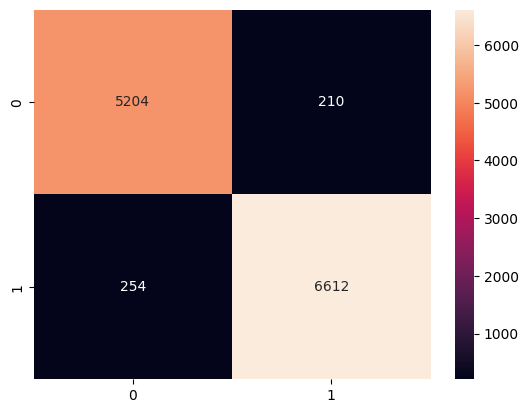

In [20]:
lgb_tfidf_no = lgb.LGBMClassifier(random_state=0, n_jobs=-1)
lgb_tfidf_no.fit(X_train_no.astype(np.float32), y_train_no)
y_pred_no = lgb_tfidf_no.predict(X_val_no.astype(np.float32))
evaluate(y_val, y_pred_no)

## LinearSVC

              precision    recall  f1-score   support

        Real      0.943     0.934     0.939      5414
        Fake      0.948     0.956     0.952      6866

    accuracy                          0.946     12280
   macro avg      0.946     0.945     0.945     12280
weighted avg      0.946     0.946     0.946     12280



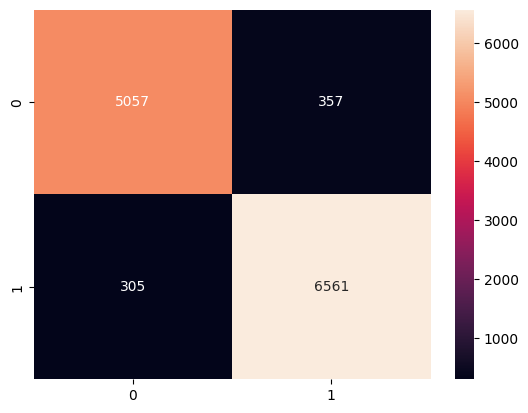

In [21]:
svc_tfidf_no = LinearSVC(dual=True, random_state=0)
svc_tfidf_no.fit(X_train_no, y_train_no)
y_pred_no = svc_tfidf_no.predict(X_val_no)
evaluate(y_val, y_pred_no)

# Baseline model

              precision    recall  f1-score   support

        Real       0.94      0.88      0.91      5414
        Fake       0.91      0.95      0.93      6866

    accuracy                           0.92     12280
   macro avg       0.92      0.92      0.92     12280
weighted avg       0.92      0.92      0.92     12280



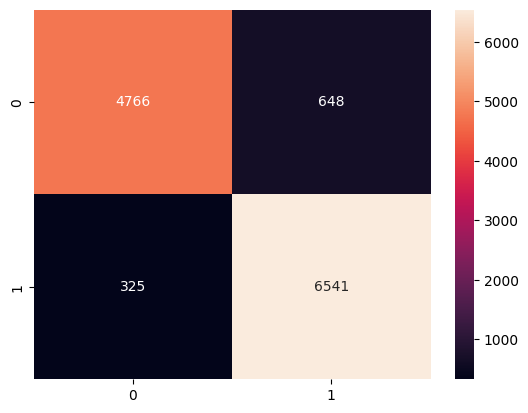

In [21]:
rf_baseline = RandomForestClassifier(random_state=0)
rf_baseline.fit(X_train_bow, y_train)
y_pred_baseline = rf_baseline.predict(X_val_bow)
evaluate(y_val, y_pred_baseline)

In [22]:
rf_baseline.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [34]:
features = ['text_word_count', 'title_word_count', 'text_unique_words', 
            'text_char_count', 'title_char_count', 'avg_word_length', 
            'sentence_count', 'special_char_count']

# test feature combinations
cv = KFold(n_splits=4, shuffle=True, random_state=0)
results_xgb = []
for i in range(1, len(features) + 1):  # Variierende Anzahl an Features
    for subset in itertools.combinations(features, i):

        X = X_train[list(subset)]
        y = y_train
    
        grid_search = GridSearchCV(
            estimator=XGBClassifier(learning_rate=0.1, 
                                    max_depth=5,
                                    subsample=0.7,
                                    colsample_bytree=0.8,
                                    random_state=0),
                param_grid={'n_estimators': [150]},
                scoring='accuracy',
                n_jobs=-1,
                return_train_score=True,
                cv=cv
        ).fit(X, y)

        result = grid_search.cv_results_
        result['f_combination'] = list(subset)
        results_xgb.append(result)

In [35]:
results_f_selection_xgb = pd.DataFrame(results_xgb)

In [ ]:
# upload_to_s3(results_f_selection_rf, 'fake-news-prediction', "datasets/results_f_selection_xgb.parquet")

File saved as datasets/results_f_selection_xgb.parquet in fake-news-prediction.


In [24]:
df_f_selection_xgb = load_file_s3('fake-news-prediction', "datasets/results_f_selection_xgb.parquet", 'parquet')

In [25]:
df_f_selection_xgb[['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'f_combination']].sort_values(by='mean_test_score', ascending=False).head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,f_combination
253,[3.566823184490204],[0.09749019145965576],[0.7855320304017372],[0.8070304017372422],"[title_word_count, text_unique_words, text_cha..."
251,[3.692900240421295],[0.09576010704040527],[0.7850705754614549],[0.8070846905537459],"[text_word_count, title_word_count, text_char_..."
232,[3.370055675506592],[0.09483373165130615],[0.7838762214983713],[0.8073832790445168],"[text_word_count, title_word_count, title_char..."
244,[3.6123124957084656],[0.09962856769561768],[0.7837947882736156],[0.8064603691639523],"[title_word_count, text_char_count, title_char..."
254,[4.391331970691681],[0.12537449598312378],[0.783441910966341],[0.8068675352877308],"[text_word_count, title_word_count, text_uniqu..."
245,[3.921709716320038],[0.09947854280471802],[0.7831976112920739],[0.8055736518277236],"[text_unique_words, text_char_count, title_cha..."
252,[3.910745680332184],[0.08860158920288086],[0.7829804560260587],[0.8051393412956931],"[text_word_count, text_unique_words, text_char..."
250,[3.380977511405945],[0.10192924737930298],[0.782899022801303],[0.8061074918566775],"[text_word_count, title_word_count, text_uniqu..."
240,[3.8965378403663635],[0.09487831592559814],[0.7828718783930511],[0.8062794064422729],"[title_word_count, text_unique_words, text_cha..."
237,[3.6244653463363647],[0.09370863437652588],[0.7827361563517916],[0.8054650741947158],"[text_word_count, text_unique_words, title_cha..."


In [26]:
df_f_selection_xgb.loc[253, 'f_combination']

array(['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count'], dtype=object)

              precision    recall  f1-score   support

        Real      0.802     0.711     0.754      5414
        Fake      0.791     0.862     0.825      6866

    accuracy                          0.795     12280
   macro avg      0.797     0.786     0.789     12280
weighted avg      0.796     0.795     0.793     12280



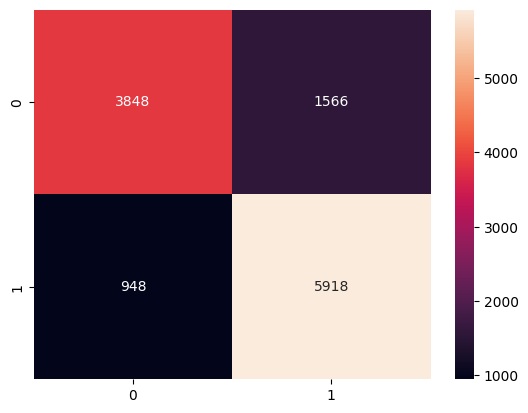

In [27]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=150,
                    max_depth=5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    random_state=0)

xgb.fit(X_train[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']], y_train)
y_pred_xgb = xgb.predict(X_val[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']])
evaluate(y_val, y_pred_xgb)

In [ ]:
# Trainingszeit messen
# start_train = time.time()
# model.fit(X_train, y_train)
# end_train = time.time()
# training_time = end_train - start_train

# Inference-Zeit messen (Vorhersage auf Test-Set)
# start_infer = time.time()
# model.predict(X_test)
# end_infer = time.time()
# inference_time = end_infer - start_infer

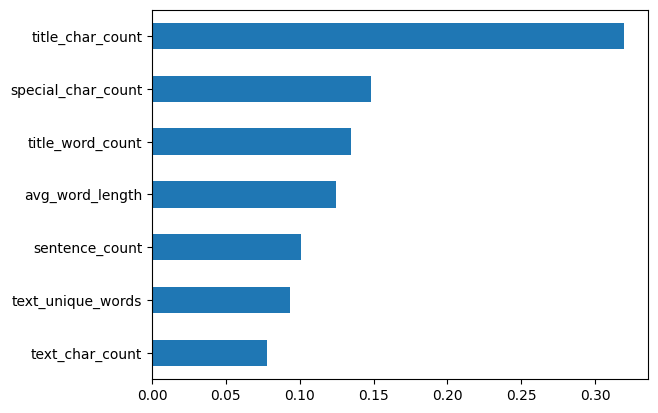

In [56]:
pd.DataFrame(data=xgb.feature_importances_, index=xgb.feature_names_in_).sort_values(by=0, ascending=True).plot(kind='barh', legend=False);

Train XGBoost with different feature set

              precision    recall  f1-score   support

        Real      0.799     0.712     0.753      5414
        Fake      0.791     0.859     0.823      6866

    accuracy                          0.794     12280
   macro avg      0.795     0.785     0.788     12280
weighted avg      0.794     0.794     0.792     12280



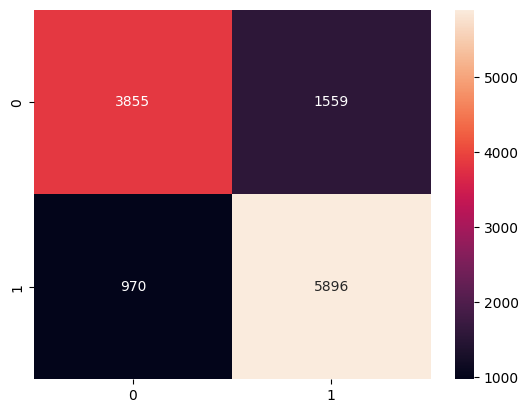

In [23]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=150,
                    max_depth=5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    random_state=0)

xgb.fit(X_train[num_cols], y_train)
y_pred_xgb = xgb.predict(X_val[num_cols])
evaluate(y_val, y_pred_xgb)

# Feature Selection

## Train Random Forest with different feature set

              precision    recall  f1-score   support

        Real       0.79      0.69      0.74      5414
        Fake       0.78      0.86      0.82      6866

    accuracy                           0.78     12280
   macro avg       0.78      0.77      0.78     12280
weighted avg       0.78      0.78      0.78     12280



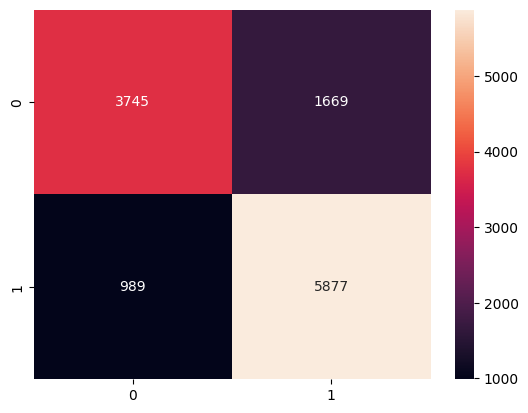

In [25]:
rf = RandomForestClassifier(min_samples_leaf=10, max_depth=10, n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train[num_cols], y_train)
y_pred_rf = rf.predict(X_val[num_cols])
evaluate(y_val, y_pred_rf)

Plot Feature Importances for Random Forest

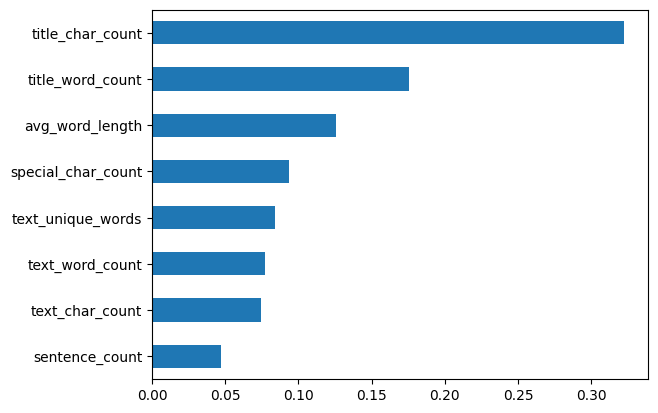

In [29]:
pd.DataFrame(data=rf.feature_importances_, index=rf.feature_names_in_).sort_values(by=0, ascending=True).plot(kind='barh', legend=False);

Train Random Forest with different feature set

In [18]:
features = ['text_word_count', 'title_word_count', 'text_unique_words', 
            'text_char_count', 'title_char_count', 'avg_word_length', 
            'sentence_count', 'special_char_count']

# test feature combinations
cv = KFold(n_splits=4, shuffle=True, random_state=0)
results = []
for i in range(1, len(features) + 1):  # Variierende Anzahl an Features
    for subset in itertools.combinations(features, i):

        X = X_train[list(subset)]
        y = y_train
    
        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(min_samples_leaf=10, max_depth=10, random_state=0, n_jobs=-1),
                param_grid={'n_estimators': [100]},
                scoring='accuracy',
                n_jobs=2,
                return_train_score=True,
                cv=cv
        ).fit(X, y)

        result = grid_search.cv_results_
        result['f_combination'] = subset
        results.append(result)

In [19]:
results_f_selection_rf = pd.DataFrame(results)

In [21]:
upload_to_s3(results_f_selection_rf, 'fake-news-prediction', "datasets/results_f_selection_rf.parquet")

File saved as datasets/results_f_selection_rf.parquet in fake-news-prediction.


In [22]:
df_f_selection_rf = load_file_s3('fake-news-prediction', "datasets/results_f_selection_rf.parquet", 'parquet')

In [23]:
df_f_selection_rf[['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'f_combination']].sort_values(by='mean_test_score', ascending=False).head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,f_combination
253,[3.566823184490204],[0.09749019145965576],[0.7855320304017372],[0.8070304017372422],"[title_word_count, text_unique_words, text_cha..."
251,[3.692900240421295],[0.09576010704040527],[0.7850705754614549],[0.8070846905537459],"[text_word_count, title_word_count, text_char_..."
232,[3.370055675506592],[0.09483373165130615],[0.7838762214983713],[0.8073832790445168],"[text_word_count, title_word_count, title_char..."
244,[3.6123124957084656],[0.09962856769561768],[0.7837947882736156],[0.8064603691639523],"[title_word_count, text_char_count, title_char..."
254,[4.391331970691681],[0.12537449598312378],[0.783441910966341],[0.8068675352877308],"[text_word_count, title_word_count, text_uniqu..."
245,[3.921709716320038],[0.09947854280471802],[0.7831976112920739],[0.8055736518277236],"[text_unique_words, text_char_count, title_cha..."
252,[3.910745680332184],[0.08860158920288086],[0.7829804560260587],[0.8051393412956931],"[text_word_count, text_unique_words, text_char..."
250,[3.380977511405945],[0.10192924737930298],[0.782899022801303],[0.8061074918566775],"[text_word_count, title_word_count, text_uniqu..."
240,[3.8965378403663635],[0.09487831592559814],[0.7828718783930511],[0.8062794064422729],"[title_word_count, text_unique_words, text_cha..."
237,[3.6244653463363647],[0.09370863437652588],[0.7827361563517916],[0.8054650741947158],"[text_word_count, text_unique_words, title_cha..."


In [49]:
df_f_selection_rf.loc[253, 'f_combination']

array(['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count'], dtype=object)

              precision    recall  f1-score   support

        Real       0.79      0.70      0.74      5414
        Fake       0.78      0.85      0.82      6866

    accuracy                           0.78     12280
   macro avg       0.78      0.77      0.78     12280
weighted avg       0.78      0.78      0.78     12280



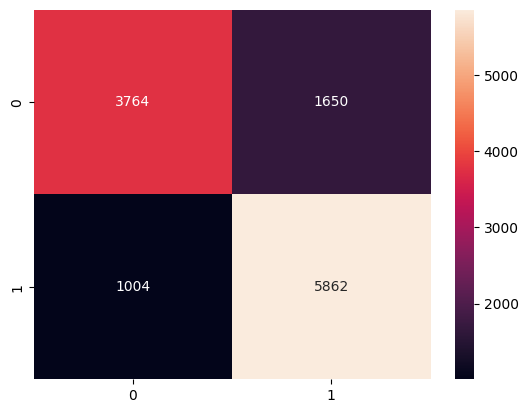

In [51]:
rf = RandomForestClassifier(min_samples_leaf=10, max_depth=10, n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_train[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']], y_train)
y_pred_rf = rf.predict(X_val[['title_word_count', 'text_unique_words', 'text_char_count',
       'title_char_count', 'avg_word_length', 'sentence_count',
       'special_char_count']])
evaluate(y_val, y_pred_rf)

## Train XGBoost with different feature set

## Train LigtGBM with different feature set

In [17]:
features = ['text_word_count', 'title_word_count', 'text_unique_words', 
            'text_char_count', 'title_char_count', 'avg_word_length', 
            'sentence_count', 'special_char_count']

# test feature combinations
cv = KFold(n_splits=4, shuffle=True, random_state=0)
results = []
for i in range(1, len(features) + 1):  # Variierende Anzahl an Features
    for subset in itertools.combinations(features, i):

        X = X_train[list(subset)].astype(np.float32)
        y = y_train
    
        grid_search = GridSearchCV(
            estimator=lgb.LGBMClassifier(random_state=0, n_jobs=-1),
                param_grid={'n_estimators': [100]},
                scoring='accuracy',
                n_jobs=-1,
                return_train_score=True,
                cv=cv
        ).fit(X, y)

        result = grid_search.cv_results_
        result['f_combination'] = subset
        results.append(result)

[LightGBM] [Info] Number of positive: 15344, number of negative: 12286
[LightGBM] [Info] Number of positive: 15387, number of negative: 12243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 27630, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556895 -> initscore=0.228569
[LightGBM] [Info] Start training from score 0.228569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 27630, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555338 -> initscore=0.222264
[LightGBM] [Info] Start training from score 0.222264
[LightGBM] [Info] Nu

In [18]:
results_f_selection_lgbm = pd.DataFrame(results)

In [19]:
upload_to_s3(results_f_selection_lgbm, 'fake-news-prediction', "datasets/results_f_selection_lgbm.parquet")

File saved as datasets/results_f_selection_lgbm.parquet in fake-news-prediction.


In [22]:
results_f_selection_lgbm[['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'f_combination']].sort_values(by='mean_test_score', ascending=False).head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,f_combination
254,[1.6544703841209412],[0.06736582517623901],[0.7964169381107491],[0.8264024610930147],"(text_word_count, title_word_count, text_uniqu..."
250,[1.0168614983558655],[0.0798458456993103],[0.7959826275787187],[0.8249004705030764],"(text_word_count, title_word_count, text_uniqu..."
253,[3.155293047428131],[0.06365275382995605],[0.7957111834961997],[0.8253981179876946],"(title_word_count, text_unique_words, text_cha..."
244,[2.392219066619873],[0.0545426607131958],[0.7956840390879479],[0.8216793340571842],"(title_word_count, text_char_count, title_char..."
251,[0.6806513667106628],[0.06315279006958008],[0.7955754614549404],[0.8237061165399928],"(text_word_count, title_word_count, text_char_..."
232,[3.550982356071472],[0.06468886137008667],[0.7947339847991315],[0.8230365544697792],"(text_word_count, title_word_count, title_char..."
252,[1.0431621670722961],[0.07422751188278198],[0.7931867535287731],[0.8219779225479551],"(text_word_count, text_unique_words, text_char..."
245,[1.1021365523338318],[0.06661885976791382],[0.7929967426710098],[0.820919290626131],"(text_unique_words, text_char_count, title_cha..."
243,[0.9288991689682007],[0.07135039567947388],[0.7928610206297504],[0.8207654723127036],"(title_word_count, text_unique_words, title_ch..."
238,[1.5457570552825928],[0.07210904359817505],[0.79185667752443],[0.8188020267824829],"(text_word_count, text_char_count, title_char_..."


In [25]:
results_f_selection_lgbm.loc[254, 'f_combination']

('text_word_count',
 'title_word_count',
 'text_unique_words',
 'text_char_count',
 'title_char_count',
 'avg_word_length',
 'sentence_count',
 'special_char_count')

# Experiment Tracking with MLflow

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlflow-fake-news")

<Experiment: artifact_location='s3://fake-news-prediction/1', creation_time=1742206809372, experiment_id='1', last_update_time=1742206809372, lifecycle_stage='active', name='mlflow-fake-news', tags={}>

In [11]:
def run_optimization(X_train, y_train, X_val, y_val, model_name, search_space, num_trials, name_train_data, name_val_data):

    def objective(params):

        with mlflow.start_run():
            mlflow.set_tag("model", model_name)
            mlflow.log_params(params)
            mlflow.log_param("train-data", name_train_data)
            mlflow.log_param("valid-data", name_val_data)
            mlflow.log_param("model_name", model_name)

            # Modell auswählen
            if model_name == "RandomForest":
                model = RandomForestClassifier(**params)
            elif model_name == "XGBoost":
                model = XGBClassifier(**params)
            elif model_name == "LinearSVC":
                model = LinearSVC(**params)
            elif model_name == "LightGBM":
                model = lgb.LGBMClassifier(**params, objective='binary')
            # elif model_name == "ExtraTrees":
                # model = ExtraTreesRegressor(**params)
            else:
                raise ValueError(f"Unknown model: {model_name}")

            # measure training time
            start_time = time.time()
        
            model.fit(X_train, y_train)

            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("training_time", training_time)

            # Prediction for training and validation-set
            y_train_pred = model.predict(X_train)

            # measure inference time
            start_inference_time = time.time()
            
            y_val_pred = model.predict(X_val)

            end_inference_time = time.time()
            inference_time = end_inference_time - start_inference_time
            mlflow.log_metric("inference_time", inference_time)
            
            # Metrics for training set
            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_precision = precision_score(y_train, y_train_pred)
            train_recall = recall_score(y_train, y_train_pred)
            
            # Metrics for test set
            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_precision = precision_score(y_val, y_val_pred)
            val_recall = recall_score(y_val, y_val_pred)

            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_precision", train_precision)
            mlflow.log_metric("train_recall", train_recall)

            mlflow.log_metric("accuracy", val_accuracy)
            mlflow.log_metric("precision", val_precision)
            mlflow.log_metric("recall", val_recall)

        return {'loss': val_accuracy, 'status': STATUS_OK}

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

## Experiment Tracking Random Forest

In [12]:
search_space_rf = {
        'max_depth': scope.int(hp.quniform('max_depth', 50, 100, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 150, 250, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

run_optimization(X_train_tfidf, y_train,X_val_tfidf, y_val, classifier="RandomForest", search_space=search_space_rf, num_trials=50)

🏃 View run rogue-flea-147 at: http://127.0.0.1:5000/#/experiments/1/runs/c7f70d80b3914fba92e6404901714a7d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🏃 View run legendary-robin-28 at: http://127.0.0.1:5000/#/experiments/1/runs/c9752458362c4366996378e80bdeb03e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

🏃 View run chill-bug-755 at: http://127.0.0.1:5000/#/experiments/1/runs/63cdfeb64cc94061b817921c3ce823ea

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

🏃 View run traveling-wasp-790 at: http://127.0.0.1:5000/#/experiments/1/runs/a76a680468ed413eb3c18cf1694e3ced

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

🏃 View run crawling-foal-357 at: http://127.0.0.1:5000/#/experiments/1/runs/f8e0e931853c4f99b21e950b70fcbfa0

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                      

🏃 View run unruly-ox-896 at: http://127.0.0.1:5000/#/experiments/1

## Experiment Tracking XGBoost

In [9]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
}

search_space_xgb = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 6, 1)),  # Maximaler Wert für max_depth reduziert
    "learning_rate": hp.loguniform("learning_rate", -3, -1),  # Kleinerer Bereich für learning_rate
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),  # Reduzierter Bereich für reg_alpha
    "reg_lambda": hp.loguniform("reg_lambda", -6, -2),  # Reduzierter Bereich für reg_lambda
    "objective": "binary:logistic",  # Klassifikationsziel
    "random_state": 42
}

search_space_xgb = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 6, 1)),  # Begrenze max_depth
    'n_estimators': scope.int(hp.quniform("n_estimators", 50, 200, 50)),  # Variabel statt fix
    'learning_rate': hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),  # Falls du es optimieren willst
    'tree_method': 'hist',  # Nutzt effizientere Berechnung
    'seed': 0
}

In [24]:
search_space_xgb = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 12, 1)),  # Begrenze max_depth
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 150, 1)),  # Variabel statt fix
    'learning_rate': hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),  # Falls du es optimieren willst
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    # 'tree_method': 'hist',  # Nutzt effizientere Berechnung
    'seed': 0
}

run_optimization(X_train_bow, y_train, X_val_bow, y_val, model_name='XGBoost', search_space=search_space_xgb, num_trials=10, name_train_data='X_train_bow', name_val_data='X_val_bow')

🏃 View run powerful-finch-343 at: http://127.0.0.1:5000/#/experiments/1/runs/b83542d9e550435284127baa4826ea67                                                 

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

🏃 View run loud-shark-273 at: http://127.0.0.1:5000/#/experiments/1/runs/e741fe9062a04fb0a3e610bab1d48f45                                                     

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

🏃 View run rogue-colt-453 at: http://127.0.0.1:5000/#/experiments/1/runs/a99e13e7b25a47a8946c6be33176804c                                                     

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                                                                                                   

🏃 View run gentle-yak-837 at: http://127

In [8]:
def objective(params, X_train_tfidf, y_train, X_val_tfidf, y_val):
    try:
        # Create DMatrix
        train = xgb.DMatrix(X_train_tfidf, label=y_train)
        valid = xgb.DMatrix(X_val_tfidf, label=y_val)

        #with mlflow.start_run():
            #mlflow.set_tag("model", "xgboost")
            #mlflow.log_param("model_name", "xgboost")
            #mlflow.log_params(params)

            # Train
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=25,  # Weniger Boost-Runden
            evals=[(valid, 'validation')],
            early_stopping_rounds=20
        )

        # Prediction
        y_pred_prob = booster.predict(valid)

        y_pred = (y_pred_prob > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)

        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

            #mlflow.log_metric("accuracy", accuracy)
            #mlflow.log_metric("precision", precision)
            #mlflow.log_metric("recall", recall)

        return {'loss': accuracy, 'status': STATUS_OK}

    except Exception as e:
        print(f"Error occurred during training or evaluation: {e}")
        return {'loss': float('inf'), 'status': STATUS_OK}

# Define search space for`hyperopt`
search_space_xgb = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 6, 1)),  # Maximaler Wert für max_depth reduziert
    "learning_rate": hp.loguniform("learning_rate", -3, -1),  # Kleinerer Bereich für learning_rate
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),  # Reduzierter Bereich für reg_alpha
    "reg_lambda": hp.loguniform("reg_lambda", -6, -2),  # Reduzierter Bereich für reg_lambda
    "objective": "binary:logistic",  # Klassifikationsziel
    "random_state": 42
}

# Übergebe deine Trainingsdaten an die `objective`-Funktion
# rstate = np.random.default_rng(42)
best_result = fmin(
    fn=lambda params: objective(params, X_train_tfidf, y_train, X_val_tfidf, y_val),
    space=search_space_xgb,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials()
)


[0]	validation-logloss:0.55834                        
[1]	validation-logloss:0.47412                        
[2]	validation-logloss:0.41195                        
[3]	validation-logloss:0.36646                        
[4]	validation-logloss:0.33238                        
[5]	validation-logloss:0.30420                        
[6]	validation-logloss:0.28353                        
[7]	validation-logloss:0.26669                        
[8]	validation-logloss:0.25274                        
[9]	validation-logloss:0.24076                        
[10]	validation-logloss:0.23030                       
[11]	validation-logloss:0.22098                       
[12]	validation-logloss:0.21327                       
[13]	validation-logloss:0.20632                       
[14]	validation-logloss:0.19935                       
[15]	validation-logloss:0.19430                       
[16]	validation-logloss:0.18997                       
[17]	validation-logloss:0.18418                       
[18]	valid

: 

## Experiment Tracking LightGMB

In [16]:
search_space_lgbm = {
    # 'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 1)),  
    'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),  
    'learning_rate': hp.loguniform('learning_rate', -1, -0.5),  # log-uniform für feine Abstufungen
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 150, 1)),  
    # 'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 50, 1)),  
    'subsample': hp.uniform('subsample', 0.7, 1.0),  
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),  
    # 'reg_alpha': hp.loguniform('reg_alpha', -5, 1),  
    # 'reg_lambda': hp.loguniform('reg_lambda', -5, 1),  
    'seed': 0
}

run_optimization(X_train_bow_num.astype(np.float32), y_train, X_val_bow_num.astype(np.float32), y_val, model_name='LightGBM', search_space=search_space_lgbm, num_trials=15, name_train_data='X_train_bow_num', name_val_data='X_val_bow_num')

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?][LightGBM] [Info] Number of positive: 20490, number of negative: 16350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.998667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                   
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709
[LightGBM] [Info] Start training from score 0.225709  
  0%|          | 0/15 [00:21<?, ?trial/s, best loss=?]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run loud-snail-397 at: http://127.0.0.1:5000/#/experiments/1/runs/0f8e5cb9847d44938696ae2fb95be5a1

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.074799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
  7%|▋         | 1/15 [00:57<08:36, 36.93s/trial, best loss: 0.9769543973941368]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run kindly-loon-152 at: http://127.0.0.1:5000/#/experiments/1/runs/f8c7ca0233a54ef8b89c26e257143f9e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.709031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
 13%|█▎        | 2/15 [01:34<07:54, 36.49s/trial, best loss: 0.9769543973941368]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run rogue-asp-228 at: http://127.0.0.1:5000/#/experiments/1/runs/8aa191336fc74d12a93fbcd6a13bdf72

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.983378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709 
[LightGBM] [Info] Start training from score 0.225709                           
 20%|██        | 3/15 [02:04<06:42, 33.56s/trial, best loss: 0.974185667752443]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run thundering-swan-270 at: http://127.0.0.1:5000/#/experiments/1/runs/33a03d97a21048e8aadf6dfae4f257b4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350         
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.896844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                            
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709 
[LightGBM] [Info] Start training from score 0.225709                           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run judicious-toad-878 at: http://127.0.0.1:5000/#/experiments/1/runs/fcea06d85c20429a96a587678792e95a

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                   

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.823588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
 33%|███▎      | 5/15 [03:04<05:12, 31.21s/trial, best loss: 0.9726384364820847]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run likeable-ray-6 at: http://127.0.0.1:5000/#/experiments/1/runs/805c26cf0acf403ba0948a4f027ad330

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.938910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[Lig

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run calm-frog-221 at: http://127.0.0.1:5000/#/experiments/1/runs/0fe5f1eab0174411a8e714c84522d705

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.886125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
 47%|████▋     | 7/15 [04:07<04:13, 31.65s/trial, best loss: 0.9726384364820847]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run fortunate-wren-418 at: http://127.0.0.1:5000/#/experiments/1/runs/09f17325ae804ba1af71c7a5fcb9a49b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.795125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run powerful-dolphin-601 at: http://127.0.0.1:5000/#/experiments/1/runs/e4c8ed3109be4f4799d05057a57b6ce5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.768014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
 60%|██████    | 9/15 [05:17<03:19, 33.24s/trial, best loss: 0.9726384364820847]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run trusting-snake-388 at: http://127.0.0.1:5000/#/experiments/1/runs/0dcff22baf564f349dff2eef9bd6d949

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350           
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.803359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                                              
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709   
[LightGBM] [Info] Start training from score 0.225709                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf       
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf  

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run delightful-gull-891 at: http://127.0.0.1:5000/#/experiments/1/runs/0aa1a093814847d284684cb1e86712fc

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350           
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.336882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, be

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run fearless-carp-709 at: http://127.0.0.1:5000/#/experiments/1/runs/6082bff50b2342968ab05775a6ff7fa8

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.474207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
 80%|████████  | 12/15 [06:47<01:32, 30.96s/trial, best loss: 0.972557003257329]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run amusing-robin-374 at: http://127.0.0.1:5000/#/experiments/1/runs/2c3ebe1219344f2786b644e0a057d7f7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.842257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run invincible-sheep-784 at: http://127.0.0.1:5000/#/experiments/1/runs/6c4e6824c8924be992d14e08d707d8f6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

[LightGBM] [Info] Number of positive: 20490, number of negative: 16350          
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.459988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102778                                             
[LightGBM] [Info] Number of data points in the train set: 36840, number of used features: 18461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556189 -> initscore=0.225709  
[LightGBM] [Info] Start training from score 0.225709                            
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, bes

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🏃 View run upbeat-rat-716 at: http://127.0.0.1:5000/#/experiments/1/runs/abaf64114bcc475e8ac541520bfe117b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

100%|██████████| 15/15 [08:00<00:00, 32.04s/trial, best loss: 0.971986970684039]


🏃 View run upbeat-rat-716 at: http://127.0.0.1:5000/#/experiments/1/runs/abaf64114bcc475e8ac541520bfe117b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                    

100%|██████████| 15/15 [08:00<00:00, 32.04s/trial, best loss: 0.971986970684039]


## Experiment Tracking SVM

In [33]:
search_space_svc = {
    # "C": hp.loguniform("C", np.log(0.01), np.log(10)),
    'C': hp.uniform('C', 0, 10),
    "class_weight": hp.choice("class_weight", [None, "balanced"]),
    "loss": hp.choice("loss", ["hinge", "squared_hinge"]),  # Unterschiedliche Verlustfunktionen testen
    "max_iter": scope.int(hp.quniform("max_iter", 3000, 5000, 100))
}

run_optimization(X_train_tfidf, y_train, X_val_tfidf, y_val, model_name='LinearSVC', search_space=search_space_svc, num_trials=100, name_train_data='X_train_tfidf', name_val_data='X_val_tfidf')

🏃 View run salty-cub-182 at: http://127.0.0.1:5000/#/experiments/1/runs/943b79a9aadc4bc487396208a81c1e79

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🏃 View run fearless-croc-526 at: http://127.0.0.1:5000/#/experiments/1/runs/fe709d237225477da4eb5e0355727233

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

🏃 View run clumsy-mink-151 at: http://127.0.0.1:5000/#/experiments/1/runs/2b4aa7d262ea402188a1d314cf49b774

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

🏃 View run welcoming-perch-792 at: http://127.0.0.1:5000/#/experiments/1/runs/287c7f70f81b4463a957a4a7f2889c45

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

🏃 View run adorable-shoat-657 at: http://127.0.0.1:5000/#/experiments/1/runs/3e48a59db47443eeabb0ed00dc46d28c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1                     

🏃 View run powerful-calf-311 at: http://127.0.0.1:5000/#/experim

# validate models on test dataset

In [8]:
X_combined = pd.concat([X_train, X_val])
# Drop unused columns
X_combined = X_combined.drop(columns=['text', 'title', 'title_text', 'language'], errors='ignore')
y_combined = pd.concat([y_train, y_val])

In [9]:
# BoW + Numerical Features
# Define preprocessor for Bag of words vectorization (Numerical columns remain unchanged)
preprocessor_bow = ColumnTransformer([
    ('text', CountVectorizer(), text_col)
], remainder='passthrough')

# Perform transformation
X_combined_bow_num = preprocessor_bow.fit_transform(X_combined)

In [10]:
X_test_bow_num = preprocessor_bow.transform(X_test)

In [8]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

client.search_experiments()

[<Experiment: artifact_location='s3://fake-news-prediction/1', creation_time=1742206809372, experiment_id='1', last_update_time=1742206809372, lifecycle_stage='active', name='mlflow-fake-news', tags={}>,
 <Experiment: artifact_location='s3://fake-news-prediction/0', creation_time=1742206522586, experiment_id='0', last_update_time=1742206522586, lifecycle_stage='active', name='Default', tags={}>]

In [17]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="params.model_name ='LightGBM' and metrics.accuracy > 0.977",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"]
)

for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f}, params: {run.data.params}")

In [11]:
lgbmClassifier=lgb.LGBMClassifier(colsample_bytree=0.912817706120575, 
                                  learning_rate=0.3790709434778987, 
                                  max_depth=13, 
                                  n_estimators=111,
                                  subsample=0.7901264064371525, 
                                  n_jobs=-1)

lgbmClassifier.fit(X_combined_bow_num.astype(np.float32), y_combined)
y_pred = lgbmClassifier.predict(X_test_bow_num.astype(np.float32))
evaluate(y_test, y_pred)

[LightGBM] [Info] Number of positive: 27356, number of negative: 21764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.957625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119884
[LightGBM] [Info] Number of data points in the train set: 49120, number of used features: 21377
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556922 -> initscore=0.228679
[LightGBM] [Info] Start training from score 0.228679


ValueError: Found input variables with inconsistent numbers of samples: [12280, 12281]

In [41]:
runs = client.search_runs(
    experiment_ids='1',
    filter_string="params.model_name ='XGBoost' and metrics.accuracy > 0.96",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"]
)

for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f}, params: {run.data.params}")

run id: 1212049f2bb04262aa4538477a5e23b4, accuracy: 0.9684, params: {'max_depth': '6', 'n_estimators': '85', 'seed': '0', 'train-data': "<Compressed Sparse Row sparse matrix of dtype 'int64'\n\twith 7397267 stored elements and shape (36840, 173341)>\n  Coords\tValues\n  (0, 110211)\t3\n  (0, 82244)\t1\n  (0, 133051)\t3\n  (0, 14779)\t3\n  (0, 80110)\t3\n  (0, 148759)\t2\n  (0, 95412)\t3\n  (0, 103322)\t6\n  (0, 71021)\t1\n  (0, 116675)\t1\n  (0, 54409)\t1\n  (0, 121451)\t2\n  (0, 132490)\t2\n  (0, 85550)\t2\n  (0, 107405)\t2\n  (0, 112785)\t2\n  (0, 52658)\t1\n  (0, 41212)\t2\n  (0, 33461)\t1\n  (0, 71041)\t3\n  (0, 130311)\t3\n  (0, 41448)\t2\n  (0, 130304)\t1\n  (0, 49679)\t2\n  (0, 148743)\t1\n  :\t:\n  (36839, 118127)\t1\n  (36839, 30023)\t1\n  (36839, 92157)\t1\n  (36839, 11480)\t1\n  (36839, 21449)\t1\n  (36839, 101506)\t1\n  (36839, 83244)\t1\n  (36839, 14346)\t1\n  (36839, 81444)\t1\n  (36839, 67033)\t1\n  (36839, 65247)\t1\n  (36839, 65805)\t1\n  (36839, 21022)\t1\n  (36839, 4

              precision    recall  f1-score   support

        Real      0.919     0.958     0.938      5400
        Fake      0.966     0.934     0.950      6881

    accuracy                          0.945     12281
   macro avg      0.943     0.946     0.944     12281
weighted avg      0.945     0.945     0.945     12281



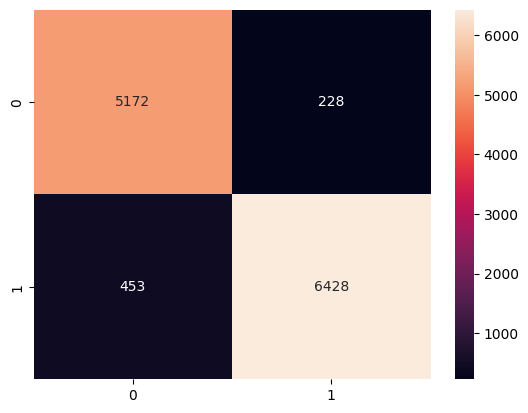

In [44]:
xgbClassifier = XGBClassifier(max_depth=6, n_estimators=8, random_state=0, n_jobs=-1)
xgbClassifier.fit(X_combined_bow_num, y_combined)
y_pred = xgbClassifier.predict(X_test_bow_num.astype(np.float32))
evaluate(y_test, y_pred)

In [45]:
runs = client.search_runs(
    experiment_ids='1',
    filter_string="params.model_name ='LinearSVC' and metrics.accuracy > 0.957",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"]
)

for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f}, params: {run.data.params}")

run id: 39dbb1699fdb4b00bbd7a393bfe95a1c, accuracy: 0.9577, params: {'C': '1.058083566272938', 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': '4200', 'train-data': 'X_train_tfidf', 'valid-data': 'X_val_tfidf', 'model_name': 'LinearSVC'}


In [54]:
# Define preprocessor for Bag of words vectorization (Numerical columns remain unchanged)
preprocessor_bow = ColumnTransformer([
    ('text', TfidfVectorizer(), text_col)
], remainder='passthrough')

# Perform transformation
X_combined_tfidf = preprocessor_bow.fit_transform(X_combined[['title_text_clean']])
X_test_tfidf = preprocessor_bow.transform(X_test[['title_text_clean']])

              precision    recall  f1-score   support

        Real      0.950     0.954     0.952      5400
        Fake      0.964     0.961     0.962      6881

    accuracy                          0.958     12281
   macro avg      0.957     0.958     0.957     12281
weighted avg      0.958     0.958     0.958     12281



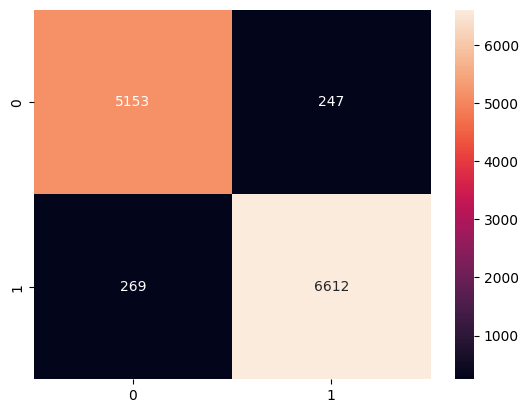

In [56]:
svcClassifier = LinearSVC(C=1.058083566272938, class_weight='balanced', loss='hinge', max_iter=4200, random_state=0)
svcClassifier.fit(X_combined_tfidf, y_combined)
y_pred = svcClassifier.predict(X_test_tfidf)
evaluate(y_test, y_pred)

In [58]:
runs = client.search_runs(
    experiment_ids='1',
    filter_string="params.model_name ='RandomForest'",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"]
)

for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f}, params: {run.data.params}")

run id: 53541ab6b3174244b7927a03954f744c, accuracy: 0.9208, params: {'max_depth': '81', 'min_samples_leaf': '2', 'min_samples_split': '7', 'n_estimators': '208', 'random_state': '42', 'train-data': 'X_train_tfidf', 'valid-data': 'X_val_tfidf', 'model_name': 'RandomForest'}


              precision    recall  f1-score   support

        Real      0.950     0.954     0.952      5400
        Fake      0.964     0.961     0.962      6881

    accuracy                          0.958     12281
   macro avg      0.957     0.958     0.957     12281
weighted avg      0.958     0.958     0.958     12281



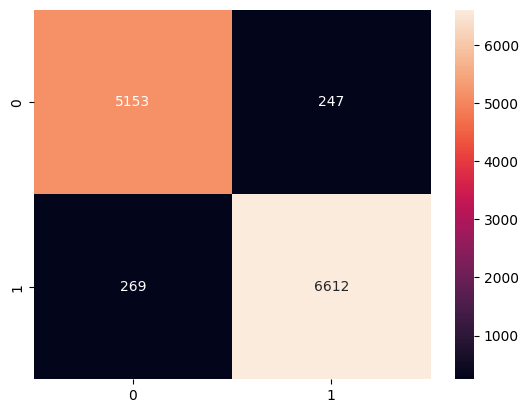

In [59]:
rfClassifier = RandomForestClassifier(max_depth=81, 
                                      min_samples_leaf=2, 
                                      min_samples_split=7, 
                                      n_estimators=208, 
                                      random_state=0)
rfClassifier.fit(X_combined_tfidf, y_combined)
y_pred = svcClassifier.predict(X_test_tfidf)
evaluate(y_test, y_pred)

# Register best model

In [37]:
params_lgbm = {
    "colsample_bytree":0.912817706120575, 
    "learning_rate":0.3790709434778987, 
    "max_depth":13, 
    "n_estimators":111,
    "subsample":0.7901264064371525
}

log_model(X_train=X_combined_bow_num.astype(np.float32), y_train=y_combined, X_test=X_test_bow_num.astype(np.float32), y_test=y_test, params=params_lgbm, model_name="LightGBM", name_train_data="X_combined_bow_num", name_val_data="X_test_bow_num")

[LightGBM] [Info] Number of positive: 27356, number of negative: 21764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 11.092431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119884
[LightGBM] [Info] Number of data points in the train set: 49120, number of used features: 21377
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556922 -> initscore=0.228679
[LightGBM] [Info] Start training from score 0.228679


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/04/04 08:23:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM'.
2025/04/04 08:23:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 1


🏃 View run incongruous-asp-611 at: http://127.0.0.1:5000/#/experiments/1/runs/36219e0537c043b198ad99b6e6a82955
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Created version '1' of model 'LightGBM'.


In [9]:
client.set_registered_model_alias("LightGBM", "champion", 1)